# Domain Adaptation Testing Notebook

This notebook tests the DomainAdapter class on the actual train.csv and test.csv datasets to handle distribution shifts.

Based on our previous analysis, we know:
- **Severe temporal shift**: Test data is 95.6% January while training spans full year
- **Geographic shift**: Different latitude/longitude distributions
- **All features show statistically significant shifts**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from domain_adaptation import DomainAdapter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Examine Data

In [2]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTraining data columns:")
print(train_df.columns.tolist())
print("\nFirst few rows of training data:")
print(train_df.head())

Training data shape: (7649, 8)
Test data shape: (2739, 7)

Training data columns:
['id', 'latitude', 'longitude', 'day_of_year', 'day_of_week', 'hour', 'month', 'pollution_value']

First few rows of training data:
   id  latitude  longitude  day_of_year  day_of_week  hour  month  \
0   0    51.491     -0.172          301            6     3     10   
1   1    39.386   -121.158          254            3    21      9   
2   2    51.459      0.596          301            6     3     10   
3   3    35.299   -120.613          145            2    14      5   
4   4    29.927    120.527          221            0    14      8   

   pollution_value  
0             14.5  
1             34.5  
2             10.5  
3             15.5  
4             54.5  


In [3]:
# Check for target column and date format
print("Training data info:")
print(train_df.info())
print("\nTest data info:")
print(test_df.info())

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7649 entries, 0 to 7648
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7649 non-null   int64  
 1   latitude         7636 non-null   float64
 2   longitude        7636 non-null   float64
 3   day_of_year      7649 non-null   int64  
 4   day_of_week      7649 non-null   int64  
 5   hour             7649 non-null   int64  
 6   month            7649 non-null   int64  
 7   pollution_value  7649 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 478.2 KB
None

Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2739 entries, 0 to 2738
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           2739 non-null   int64  
 1   latitude     2739 non-null   float64
 2   longitude    2739 non-null   float64
 3   day_of_year  2739 n

In [4]:
# Identify target column and date column
# Assuming target is the last column and there's a date column
potential_date_cols = [col for col in train_df.columns if 'date' in col.lower() or 'time' in col.lower()]
potential_target_cols = [col for col in train_df.columns if col.lower() in ['target', 'y', 'label'] or train_df.dtypes[col] in ['float64', 'int64']]

print(f"Potential date columns: {potential_date_cols}")
print(f"Potential target columns: {potential_target_cols}")

# Check if we need to create a date column from existing temporal features
temporal_features = ['month', 'day_of_week', 'hour', 'day_of_year']
has_temporal_features = all(col in train_df.columns for col in temporal_features)
print(f"\nHas temporal features (month, day_of_week, hour, day_of_year): {has_temporal_features}")

Potential date columns: []
Potential target columns: ['id', 'latitude', 'longitude', 'day_of_year', 'day_of_week', 'hour', 'month', 'pollution_value']

Has temporal features (month, day_of_week, hour, day_of_year): True


## 2. Data Preparation

In [5]:
# Create a synthetic date column if needed (based on temporal features)
if not potential_date_cols and has_temporal_features:
    print("Creating synthetic date column from temporal features...")
    
    def create_synthetic_date(df, base_year=2023):
        """Create synthetic dates from day_of_year and hour"""
        df = df.copy()
        
        # Create base date from day of year
        base_date = pd.to_datetime(f'{base_year}-01-01') + pd.to_timedelta(df['day_of_year'] - 1, unit='D')
        
        # Add hour information
        df['date'] = base_date + pd.to_timedelta(df['hour'], unit='H')
        
        return df
    
    train_df = create_synthetic_date(train_df, base_year=2023)
    test_df = create_synthetic_date(test_df, base_year=2024)  # Different year for test
    
    date_col = 'date'
    print(f"Created synthetic date column: {date_col}")
    
elif potential_date_cols:
    date_col = potential_date_cols[0]
    print(f"Using existing date column: {date_col}")
else:
    print("Warning: No date column found. Using index as proxy.")
    train_df['date'] = pd.date_range('2023-01-01', periods=len(train_df), freq='H')
    test_df['date'] = pd.date_range('2024-01-01', periods=len(test_df), freq='H')
    date_col = 'date'

# Identify target column (assume it's the last numeric column that's not a feature)
feature_cols = ['latitude', 'longitude', 'month', 'day_of_week', 'hour', 'day_of_year']
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
target_candidates = [col for col in numeric_cols if col not in feature_cols and col != date_col]

if target_candidates:
    target_col = target_candidates[-1]  # Take the last one
else:
    # Create synthetic target for testing
    print("Creating synthetic target for testing...")
    target_col = 'target'
    # Create target with seasonal and geographic effects
    train_df[target_col] = (
        np.sin(2 * np.pi * train_df['day_of_year'] / 365) * 10 +  # Seasonal effect
        (train_df['latitude'] - train_df['latitude'].mean()) * 0.5 +  # Geographic effect
        np.random.normal(0, 2, len(train_df))  # Noise
    )

print(f"\nUsing date column: {date_col}")
print(f"Using target column: {target_col}")
print(f"Geographic columns: ['latitude', 'longitude']")

Creating synthetic date column from temporal features...
Created synthetic date column: date

Using date column: date
Using target column: pollution_value
Geographic columns: ['latitude', 'longitude']


In [6]:
# Display basic statistics about the temporal and geographic distributions
print("TEMPORAL DISTRIBUTION COMPARISON")
print("="*50)

# Convert to datetime if needed
train_df[date_col] = pd.to_datetime(train_df[date_col])
if date_col in test_df.columns:
    test_df[date_col] = pd.to_datetime(test_df[date_col])

# Extract temporal features for comparison
if 'month' not in train_df.columns:
    train_df['month'] = train_df[date_col].dt.month
    test_df['month'] = test_df[date_col].dt.month if date_col in test_df.columns else test_df['month']

# Month distribution
train_month_dist = train_df['month'].value_counts(normalize=True).sort_index()
test_month_dist = test_df['month'].value_counts(normalize=True).sort_index()

print("Month Distribution (proportions):")
comparison_df = pd.DataFrame({
    'Train': train_month_dist,
    'Test': test_month_dist
}).fillna(0)
comparison_df['Difference'] = comparison_df['Test'] - comparison_df['Train']
print(comparison_df.round(3))

print("\nGEOGRAPHIC DISTRIBUTION COMPARISON")
print("="*50)
print("Latitude:")
print(f"  Train: mean={train_df['latitude'].mean():.2f}, std={train_df['latitude'].std():.2f}")
print(f"  Test:  mean={test_df['latitude'].mean():.2f}, std={test_df['latitude'].std():.2f}")
print("Longitude:")
print(f"  Train: mean={train_df['longitude'].mean():.2f}, std={train_df['longitude'].std():.2f}")
print(f"  Test:  mean={test_df['longitude'].mean():.2f}, std={test_df['longitude'].std():.2f}")

TEMPORAL DISTRIBUTION COMPARISON
Month Distribution (proportions):
       Train  Test  Difference
month                         
1      0.044   1.0       0.956
2      0.020   0.0      -0.020
3      0.025   0.0      -0.025
4      0.032   0.0      -0.032
5      0.232   0.0      -0.232
6      0.027   0.0      -0.027
7      0.049   0.0      -0.049
8      0.256   0.0      -0.256
9      0.166   0.0      -0.166
10     0.073   0.0      -0.073
11     0.029   0.0      -0.029
12     0.047   0.0      -0.047

GEOGRAPHIC DISTRIBUTION COMPARISON
Latitude:
  Train: mean=31.88, std=17.80
  Test:  mean=36.77, std=23.56
Longitude:
  Train: mean=32.10, std=97.81
  Test:  mean=25.16, std=72.76


## 3. Initialize Domain Adapter

In [7]:
# Initialize the DomainAdapter
adapter = DomainAdapter(
    date_col=date_col,
    geo_cols=['latitude', 'longitude'],
    random_state=42
)

print("DomainAdapter initialized successfully!")
print(f"Date column: {adapter.date_col}")
print(f"Geographic columns: {adapter.geo_cols}")

DomainAdapter initialized successfully!
Date column: date
Geographic columns: ['latitude', 'longitude']


## 4. Create Enhanced Temporal Features

In [8]:
# Add cyclical temporal features
print("Adding cyclical temporal features...")

train_enhanced = adapter.create_temporal_features(train_df)
test_enhanced = adapter.create_temporal_features(test_df)

print(f"Original features: {len(train_df.columns)}")
print(f"Enhanced features: {len(train_enhanced.columns)}")
print(f"Added features: {len(train_enhanced.columns) - len(train_df.columns)}")

# Show new features
new_features = [col for col in train_enhanced.columns if col not in train_df.columns]
print(f"\nNew temporal features: {new_features}")

Adding cyclical temporal features...
Original features: 9
Enhanced features: 23
Added features: 14

New temporal features: ['month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'is_winter', 'is_spring', 'is_summer', 'is_fall', 'is_january', 'is_weekend']


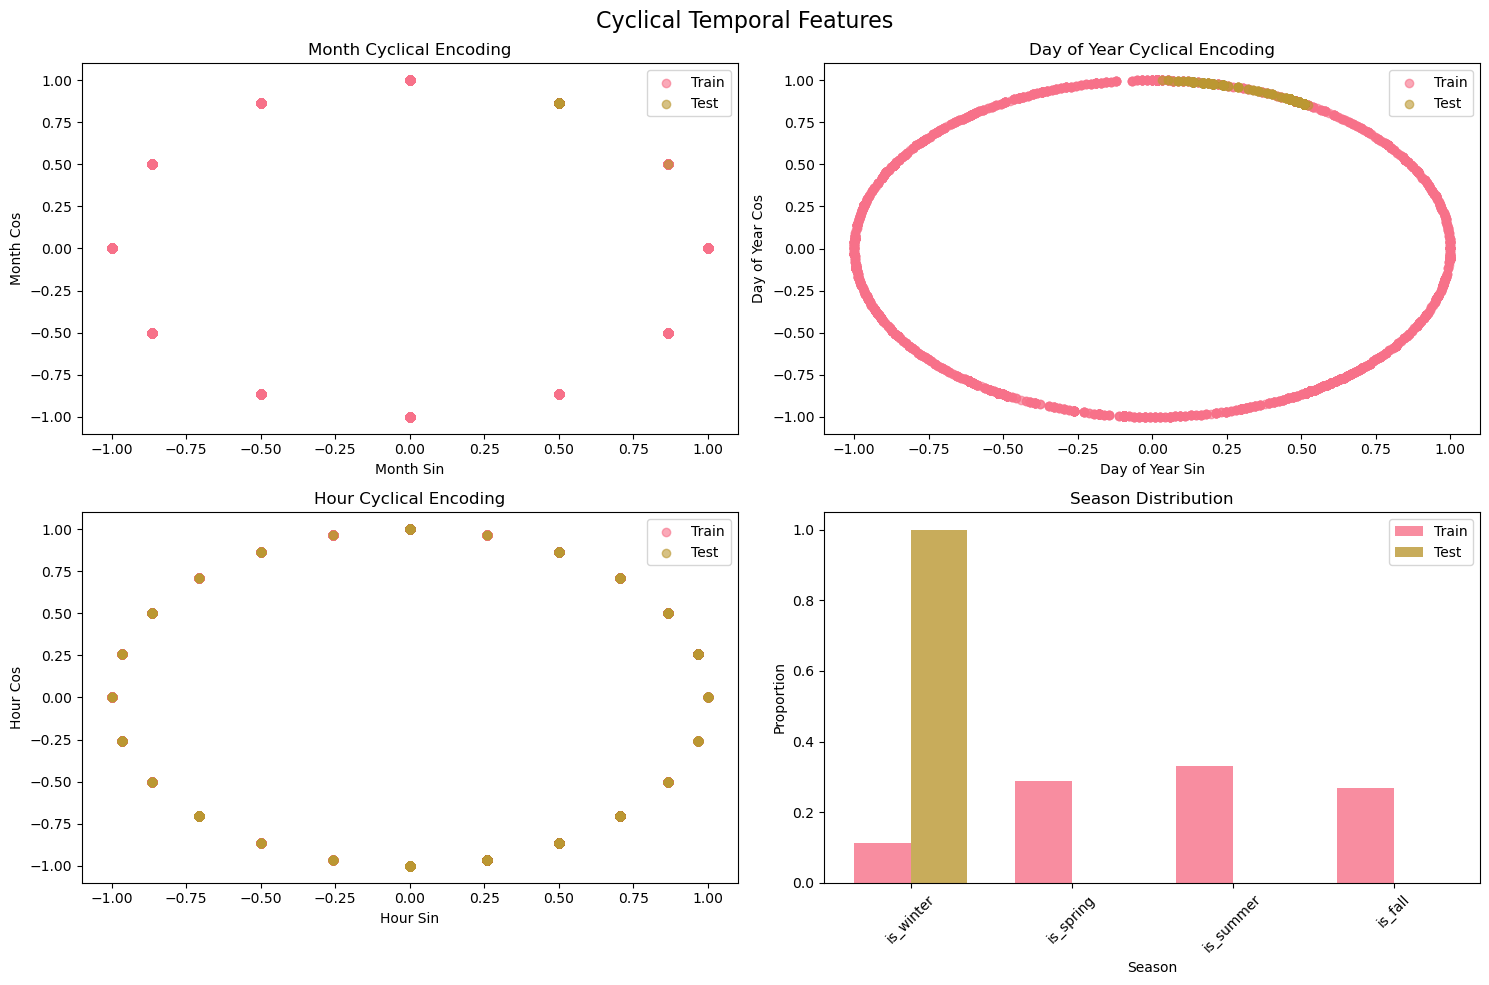

In [9]:
# Visualize the cyclical features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Cyclical Temporal Features', fontsize=16)

# Month cyclical features
axes[0,0].scatter(train_enhanced['month_sin'], train_enhanced['month_cos'], alpha=0.6, label='Train')
axes[0,0].scatter(test_enhanced['month_sin'], test_enhanced['month_cos'], alpha=0.6, label='Test')
axes[0,0].set_xlabel('Month Sin')
axes[0,0].set_ylabel('Month Cos')
axes[0,0].set_title('Month Cyclical Encoding')
axes[0,0].legend()

# Day of year cyclical features
axes[0,1].scatter(train_enhanced['day_of_year_sin'], train_enhanced['day_of_year_cos'], alpha=0.6, label='Train')
axes[0,1].scatter(test_enhanced['day_of_year_sin'], test_enhanced['day_of_year_cos'], alpha=0.6, label='Test')
axes[0,1].set_xlabel('Day of Year Sin')
axes[0,1].set_ylabel('Day of Year Cos')
axes[0,1].set_title('Day of Year Cyclical Encoding')
axes[0,1].legend()

# Hour cyclical features
axes[1,0].scatter(train_enhanced['hour_sin'], train_enhanced['hour_cos'], alpha=0.6, label='Train')
axes[1,0].scatter(test_enhanced['hour_sin'], test_enhanced['hour_cos'], alpha=0.6, label='Test')
axes[1,0].set_xlabel('Hour Sin')
axes[1,0].set_ylabel('Hour Cos')
axes[1,0].set_title('Hour Cyclical Encoding')
axes[1,0].legend()

# Season indicators
season_cols = ['is_winter', 'is_spring', 'is_summer', 'is_fall']
train_seasons = train_enhanced[season_cols].mean()
test_seasons = test_enhanced[season_cols].mean()

x_pos = np.arange(len(season_cols))
width = 0.35
axes[1,1].bar(x_pos - width/2, train_seasons, width, label='Train', alpha=0.8)
axes[1,1].bar(x_pos + width/2, test_seasons, width, label='Test', alpha=0.8)
axes[1,1].set_xlabel('Season')
axes[1,1].set_ylabel('Proportion')
axes[1,1].set_title('Season Distribution')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(season_cols, rotation=45)
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 5. Compute Domain Adaptation Weights

In [10]:
# Compute temporal weights
print("Computing temporal adaptation weights...")
temporal_weights = adapter.compute_temporal_weights(train_enhanced, test_enhanced, temporal_col='month')

print(f"Temporal weights - Mean: {temporal_weights.mean():.3f}, Std: {temporal_weights.std():.3f}")
print(f"Temporal weights - Min: {temporal_weights.min():.3f}, Max: {temporal_weights.max():.3f}")

# Compute geographic weights
print("\nComputing geographic adaptation weights...")
geographic_weights = adapter.compute_geographic_weights(train_enhanced, test_enhanced, method='proximity')

print(f"Geographic weights - Mean: {geographic_weights.mean():.3f}, Std: {geographic_weights.std():.3f}")
print(f"Geographic weights - Min: {geographic_weights.min():.3f}, Max: {geographic_weights.max():.3f}")

# Compute combined weights
print("\nComputing combined adaptation weights...")
combined_weights = adapter.compute_combined_weights(temporal_weight=0.7, geographic_weight=0.3)

print(f"Combined weights - Mean: {combined_weights.mean():.3f}, Std: {combined_weights.std():.3f}")
print(f"Combined weights - Min: {combined_weights.min():.3f}, Max: {combined_weights.max():.3f}")

Computing temporal adaptation weights...
Temporal weights - Mean: 1.000, Std: 3.759
Temporal weights - Min: 0.010, Max: 15.276

Computing geographic adaptation weights...
Geographic weights - Mean: 1.000, Std: 1.020
Geographic weights - Min: 0.068, Max: 4.757

Computing combined adaptation weights...
Combined weights - Mean: 1.000, Std: 2.718
Combined weights - Min: 0.033, Max: 12.113


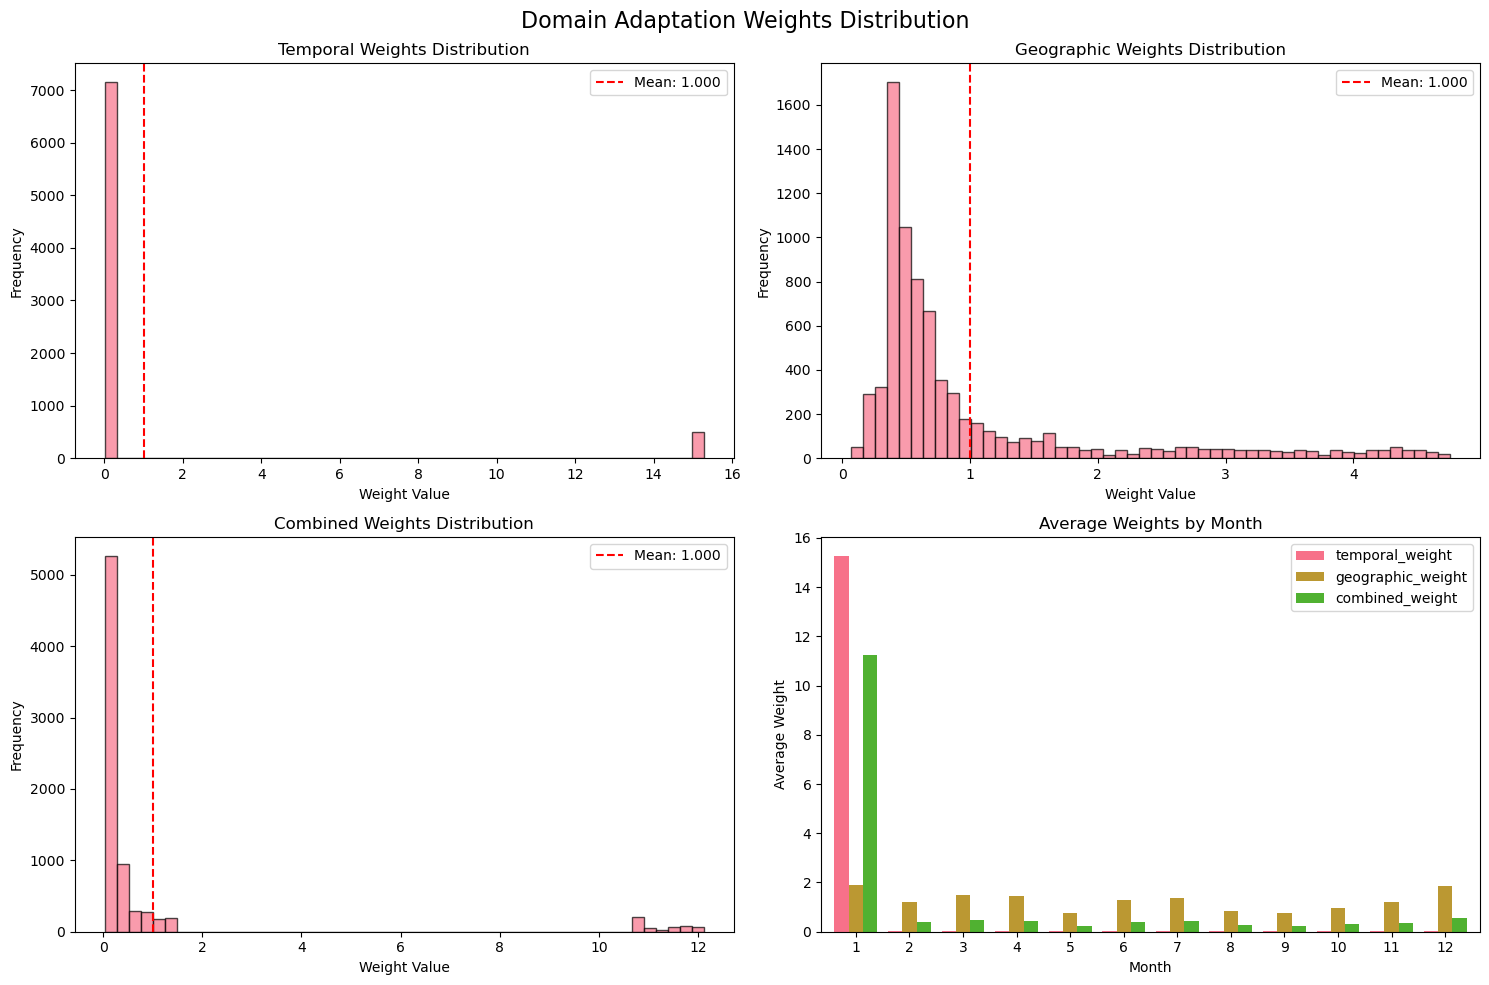

In [11]:
# Visualize the weights
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Domain Adaptation Weights Distribution', fontsize=16)

# Temporal weights histogram
axes[0,0].hist(temporal_weights, bins=50, alpha=0.7, edgecolor='black')
axes[0,0].axvline(temporal_weights.mean(), color='red', linestyle='--', label=f'Mean: {temporal_weights.mean():.3f}')
axes[0,0].set_xlabel('Weight Value')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Temporal Weights Distribution')
axes[0,0].legend()

# Geographic weights histogram
axes[0,1].hist(geographic_weights, bins=50, alpha=0.7, edgecolor='black')
axes[0,1].axvline(geographic_weights.mean(), color='red', linestyle='--', label=f'Mean: {geographic_weights.mean():.3f}')
axes[0,1].set_xlabel('Weight Value')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Geographic Weights Distribution')
axes[0,1].legend()

# Combined weights histogram
axes[1,0].hist(combined_weights, bins=50, alpha=0.7, edgecolor='black')
axes[1,0].axvline(combined_weights.mean(), color='red', linestyle='--', label=f'Mean: {combined_weights.mean():.3f}')
axes[1,0].set_xlabel('Weight Value')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Combined Weights Distribution')
axes[1,0].legend()

# Weights by month (temporal pattern)
weight_by_month = pd.DataFrame({
    'month': train_enhanced['month'],
    'temporal_weight': temporal_weights,
    'geographic_weight': geographic_weights,
    'combined_weight': combined_weights
}).groupby('month').mean()

weight_by_month.plot(kind='bar', ax=axes[1,1], width=0.8)
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Average Weight')
axes[1,1].set_title('Average Weights by Month')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 6. Run Complete Domain Adaptation Validation

In [12]:
# Run the complete validation process
print("Running domain adaptation validation...")
print("This may take a few minutes...")

# Use enhanced features for validation
validation_results = adapter.validate_adaptation(
    train_df=train_enhanced, 
    test_df=test_enhanced, 
    target_col=target_col,
    val_split=0.2
)

print("\n" + "="*60)
print("DOMAIN ADAPTATION VALIDATION RESULTS (RMSE FOCUSED)")
print("="*60)

# Display results in a formatted way
methods = ['baseline', 'temporal', 'geographic', 'combined', 'ensemble']
print(f"{'Method':<12} {'RMSE':<10} {'Improvement':<12}")
print("-" * 35)

for method in methods:
    rmse = validation_results[f'{method}_rmse']
    if method == 'baseline':
        print(f"{method:<12} {rmse:<10.4f} {'--':<12}")
    else:
        improvement = validation_results[f'{method}_improvement_pct']
        print(f"{method:<12} {rmse:<10.4f} {improvement:<12.2f}%")

# Identify best method
best_method = None
best_rmse = float('inf')
for method in methods:
    rmse = validation_results[f'{method}_rmse']
    if rmse < best_rmse:
        best_rmse = rmse
        best_method = method

print(f"\nBest performing method: {best_method.upper()} (RMSE: {best_rmse:.4f})")

Running domain adaptation validation...
This may take a few minutes...
Debug: X_train_clean shape: (6106, 21)
Debug: y_train_clean shape: (6106,)
Debug: temporal_weights shape: (6106,)
Debug: geographic_weights shape: (6106,)
Debug: combined_weights shape: (6106,)

DOMAIN ADAPTATION VALIDATION RESULTS (RMSE FOCUSED)
Method       RMSE       Improvement 
-----------------------------------
baseline     69.1523    --          
temporal     67.8244    1.92        %
geographic   67.9453    1.75        %
combined     69.1486    0.01        %
ensemble     66.2661    4.17        %

Best performing method: ENSEMBLE (RMSE: 66.2661)


In [13]:
# Get adaptation summary
summary = adapter.get_adaptation_summary()

print("\n" + "="*50)
print("ADAPTATION WEIGHTS SUMMARY")
print("="*50)

for weight_type, stats in summary.items():
    print(f"\n{weight_type.replace('_', ' ').title()}:")
    if isinstance(stats, dict):
        for key, value in stats.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.4f}")
            else:
                print(f"  {key}: {value}")


ADAPTATION WEIGHTS SUMMARY

Temporal Weights:
  mean: 1.0021
  std: 4.1242
  min: 0.0099
  max: 18.1466

Geographic Weights:
  mean: 1.0001
  std: 1.0324
  min: 0.0678
  max: 4.7763

Ensemble Weights:
  baseline: 0.0123
  temporal: 0.4861
  geographic: 0.4892
  combined: 0.0124


## 7. Visualize Validation Results

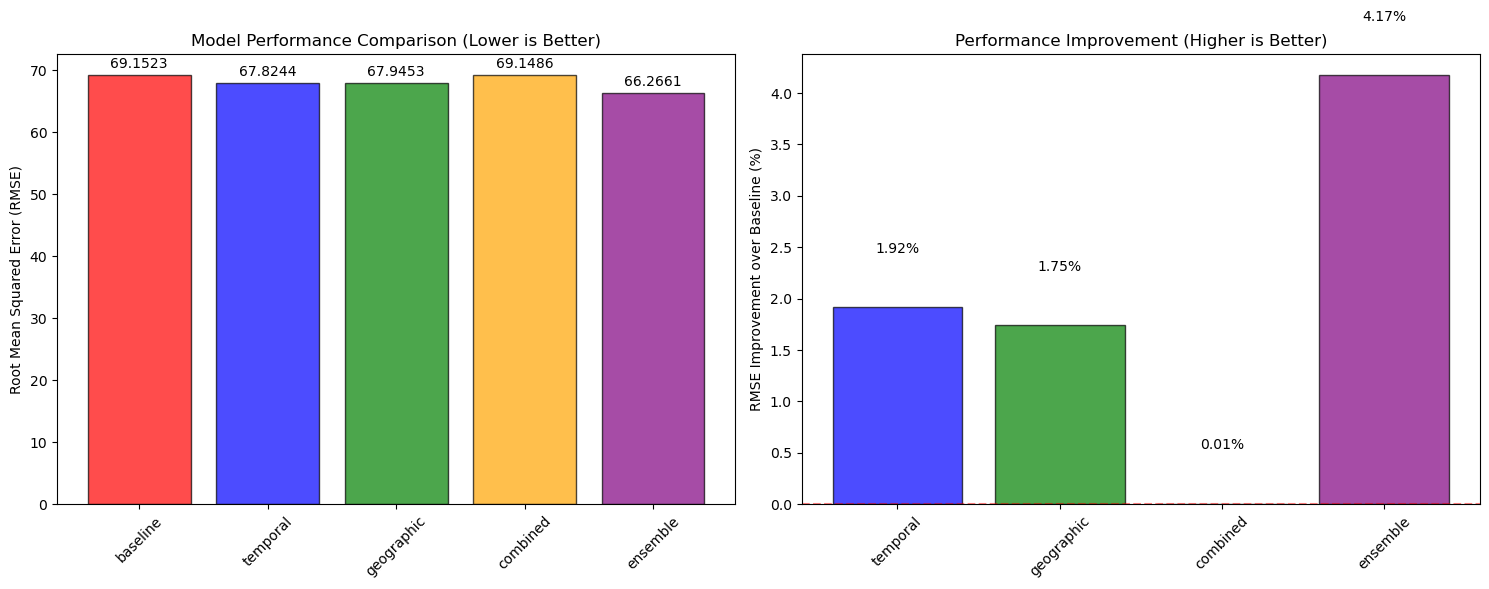

In [14]:
# Create visualization of validation results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RMSE comparison
methods = ['baseline', 'temporal', 'geographic', 'combined', 'ensemble']
rmse_values = [validation_results[f'{method}_rmse'] for method in methods]
colors = ['red', 'blue', 'green', 'orange', 'purple']

bars = axes[0].bar(methods, rmse_values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Root Mean Squared Error (RMSE)')
axes[0].set_title('Model Performance Comparison (Lower is Better)')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars, rmse_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(rmse_values), 
                f'{value:.4f}', ha='center', va='bottom')

# Improvement percentage
improvement_methods = ['temporal', 'geographic', 'combined', 'ensemble']
improvement_values = [validation_results[f'{method}_improvement_pct'] for method in improvement_methods]
improvement_colors = ['blue', 'green', 'orange', 'purple']

bars2 = axes[1].bar(improvement_methods, improvement_values, color=improvement_colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('RMSE Improvement over Baseline (%)')
axes[1].set_title('Performance Improvement (Higher is Better)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Add value labels on bars
for bar, value in zip(bars2, improvement_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{value:.2f}%', ha='center', va='bottom' if value > 0 else 'top')

plt.tight_layout()
plt.show()

## 8. Test Final Predictions on Test Set

In [15]:
# Prepare feature matrices for final prediction
# Remove non-feature columns
exclude_cols = [target_col, date_col, 'month', 'day_of_week', 'hour', 'day_of_year']  # Keep original temporal as some might be used
feature_cols = [col for col in train_enhanced.columns if col not in exclude_cols]

print(f"Using {len(feature_cols)} features for prediction:")
print(feature_cols)

# Prepare training data
X_train_final = train_enhanced[feature_cols]
y_train_final = train_enhanced[target_col]

# Fit final models with all training data
print("\nFitting final models with complete training data...")
adapter.fit_adaptation_models(X_train_final, y_train_final)

print("Models fitted successfully!")
print(f"Available models: {list(adapter.models.keys())}")

Using 17 features for prediction:
['id', 'latitude', 'longitude', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'is_winter', 'is_spring', 'is_summer', 'is_fall', 'is_january', 'is_weekend']

Fitting final models with complete training data...


Debug: X_train_clean shape: (7636, 17)
Debug: y_train_clean shape: (7636,)
Debug: temporal_weights shape: (7636,)
Debug: geographic_weights shape: (7636,)
Debug: combined_weights shape: (7636,)
Models fitted successfully!
Available models: ['baseline', 'temporal', 'geographic', 'combined']


In [16]:
# Make predictions on test set using different methods
X_test_final = test_enhanced[feature_cols]

print("Making predictions on test set...")
predictions = {}

# Get predictions from each method
for method in ['baseline', 'temporal', 'geographic', 'combined']:
    predictions[method] = adapter.predict(X_test_final, method=method)
    print(f"{method.capitalize()} predictions - Mean: {predictions[method].mean():.3f}, Std: {predictions[method].std():.3f}")

# Ensemble prediction (if weights are available)
if adapter.ensemble_weights is not None:
    predictions['ensemble'] = adapter.predict(X_test_final, method='ensemble')
    print(f"Ensemble predictions - Mean: {predictions['ensemble'].mean():.3f}, Std: {predictions['ensemble'].std():.3f}")
else:
    print("Ensemble weights not available - using combined method as ensemble")
    predictions['ensemble'] = predictions['combined']

Making predictions on test set...
Baseline predictions - Mean: 37.310, Std: 40.613
Temporal predictions - Mean: 40.080, Std: 28.562
Geographic predictions - Mean: 39.319, Std: 50.600
Combined predictions - Mean: 42.539, Std: 47.321
Ensemble predictions - Mean: 39.704, Std: 36.934


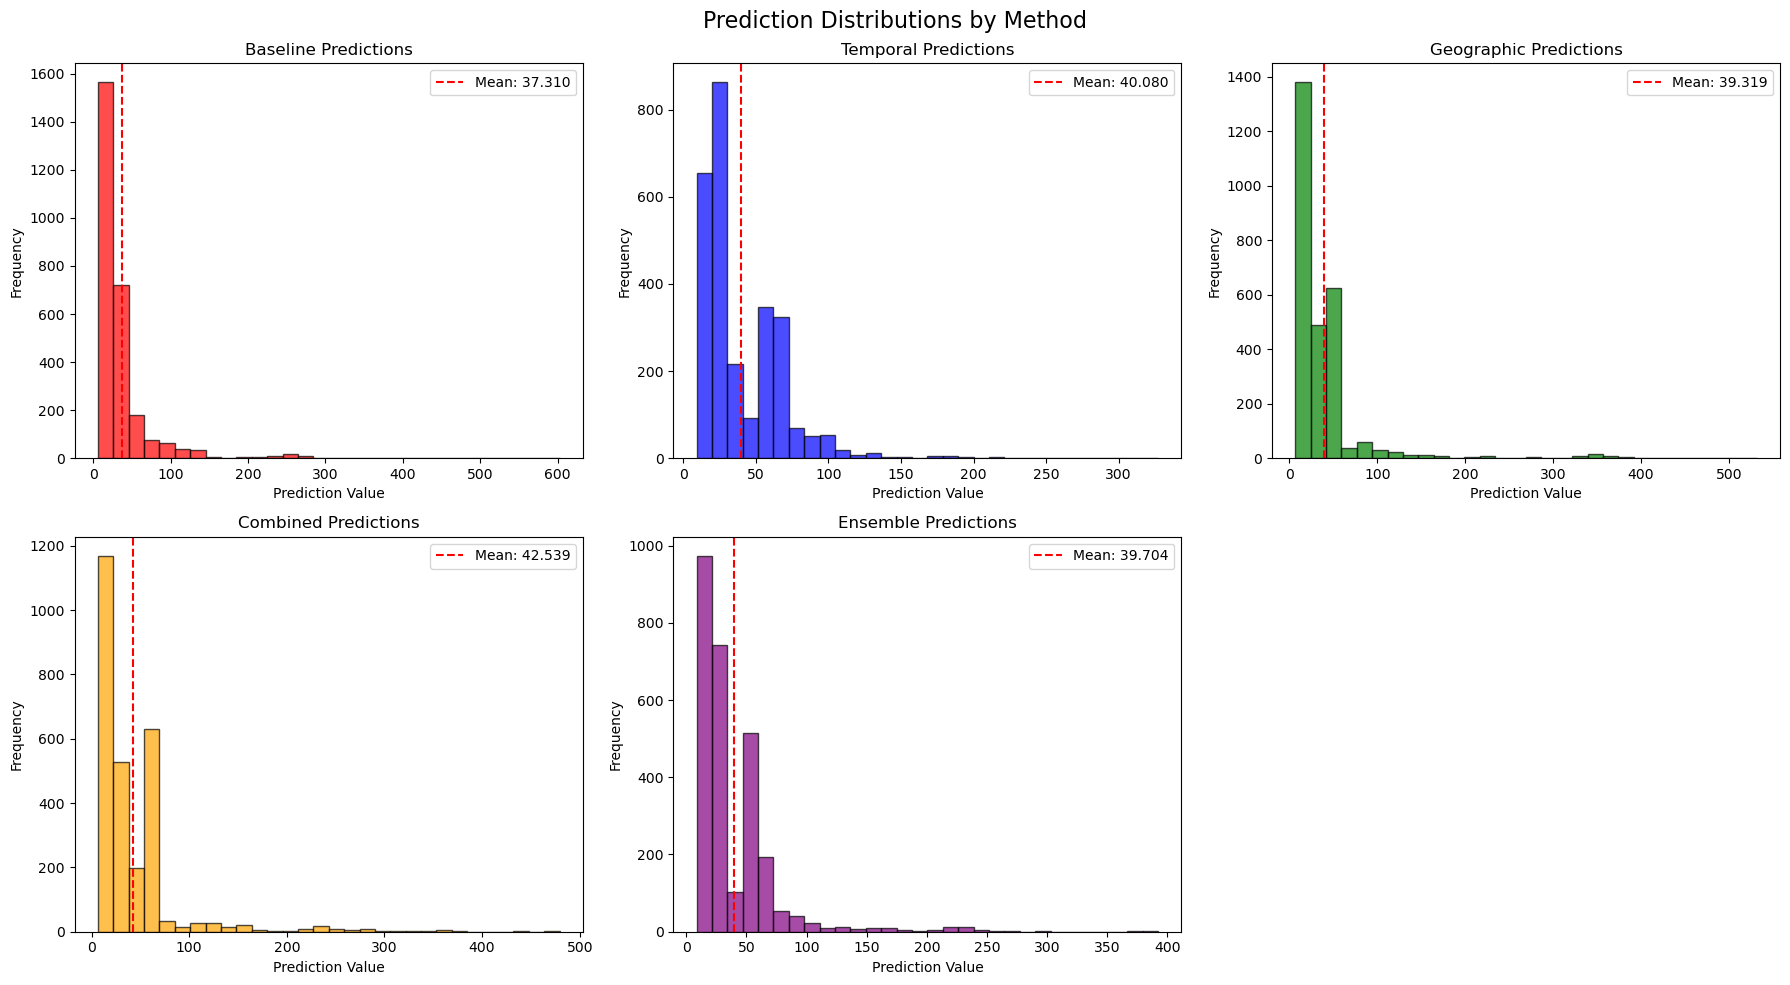

In [17]:
# Visualize prediction distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Prediction Distributions by Method', fontsize=16)

methods = ['baseline', 'temporal', 'geographic', 'combined', 'ensemble']
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, method in enumerate(methods):
    row = i // 3
    col = i % 3
    
    axes[row, col].hist(predictions[method], bins=30, alpha=0.7, color=colors[i], edgecolor='black')
    axes[row, col].axvline(predictions[method].mean(), color='red', linestyle='--', 
                          label=f'Mean: {predictions[method].mean():.3f}')
    axes[row, col].set_title(f'{method.capitalize()} Predictions')
    axes[row, col].set_xlabel('Prediction Value')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()

# Remove empty subplot
if len(methods) < 6:
    axes[1, 2].remove()

plt.tight_layout()
plt.show()

## 9. Analysis and Recommendations

In [18]:
# Analyze prediction differences
print("PREDICTION ANALYSIS")
print("="*50)

# Compare predictions between methods
baseline_pred = predictions['baseline']
best_adapted_pred = predictions[best_method]

pred_diff = best_adapted_pred - baseline_pred
print(f"Difference between {best_method} and baseline predictions:")
print(f"  Mean difference: {pred_diff.mean():.4f}")
print(f"  Std difference: {pred_diff.std():.4f}")
print(f"  Max absolute difference: {np.abs(pred_diff).max():.4f}")

# Correlation between different methods
print("\nCorrelation between prediction methods:")
pred_df = pd.DataFrame(predictions)
correlation_matrix = pred_df.corr()
print(correlation_matrix.round(3))

# Show where adaptations have biggest impact
high_impact_mask = np.abs(pred_diff) > np.percentile(np.abs(pred_diff), 90)
print(f"\nSamples with highest adaptation impact ({high_impact_mask.sum()} samples):")
if high_impact_mask.sum() > 0:
    high_impact_features = test_enhanced[high_impact_mask][['month', 'latitude', 'longitude', 'is_january']]
    print("Temporal/Geographic characteristics:")
    print(high_impact_features.describe())

PREDICTION ANALYSIS
Difference between ensemble and baseline predictions:
  Mean difference: 2.3941
  Std difference: 14.6800
  Max absolute difference: 250.0481

Correlation between prediction methods:
            baseline  temporal  geographic  combined  ensemble
baseline       1.000     0.759       0.924     0.909     0.933
temporal       0.759     1.000       0.704     0.801     0.870
geographic     0.924     0.704       1.000     0.944     0.962
combined       0.909     0.801       0.944     1.000     0.962
ensemble       0.933     0.870       0.962     0.962     1.000

Samples with highest adaptation impact (274 samples):
Temporal/Geographic characteristics:
       month    latitude  longitude  is_january
count  274.0  274.000000  274.00000       274.0
mean     1.0   25.610551   -1.13804         1.0
std      0.0   27.766354   82.94504         0.0
min      1.0  -47.269000 -116.96200         1.0
25%      1.0   19.364750  -76.90125         1.0
50%      1.0   34.725500   21.04350    

In [19]:
# Final recommendations
print("\n" + "="*60)
print("FINAL RECOMMENDATIONS")
print("="*60)

best_improvement = validation_results[f'{best_method}_improvement_pct']

print(f"1. BEST METHOD: {best_method.upper()}")
print(f"   - Achieved {best_improvement:.2f}% RMSE improvement over baseline")
print(f"   - Final RMSE: {validation_results[f'{best_method}_rmse']:.4f}")

print("\n2. KEY INSIGHTS:")
if best_improvement > 10:
    print("   ✓ Significant RMSE improvement achieved through domain adaptation")
elif best_improvement > 5:
    print("   ✓ Moderate RMSE improvement achieved through domain adaptation")
else:
    print("   ⚠ Limited RMSE improvement - distribution shift may be less severe than expected")

print("\n3. IMPLEMENTATION STRATEGY:")
if 'temporal' in best_method:
    print("   → Focus on temporal reweighting and cyclical features")
    print("   → Consider seasonal validation splits")
if 'geographic' in best_method:
    print("   → Focus on geographic proximity weighting")
    print("   → Consider spatial cross-validation")
if 'ensemble' in best_method:
    print("   → Use ensemble of multiple adaptation strategies")
    print("   → Monitor individual component performance")

print("\n4. DEPLOYMENT CONSIDERATIONS:")
print("   → Monitor model RMSE performance over time")
print("   → Retrain with domain adaptation when distribution shifts occur")
print("   → Use validation framework to assess RMSE improvement effectiveness")

# Save predictions
print("\n5. SAVING RESULTS:")
prediction_df = pd.DataFrame(predictions)
prediction_df.to_csv('domain_adapted_predictions.csv', index=False)
print("   ✓ Predictions saved to 'domain_adapted_predictions.csv'")

# Save validation results
results_df = pd.DataFrame([validation_results]).T
results_df.columns = ['Value']
results_df.to_csv('domain_adaptation_validation_results.csv')
print("   ✓ Validation results saved to 'domain_adaptation_validation_results.csv'")


FINAL RECOMMENDATIONS
1. BEST METHOD: ENSEMBLE
   - Achieved 4.17% RMSE improvement over baseline
   - Final RMSE: 66.2661

2. KEY INSIGHTS:
   ⚠ Limited RMSE improvement - distribution shift may be less severe than expected

3. IMPLEMENTATION STRATEGY:
   → Use ensemble of multiple adaptation strategies
   → Monitor individual component performance

4. DEPLOYMENT CONSIDERATIONS:
   → Monitor model RMSE performance over time
   → Retrain with domain adaptation when distribution shifts occur
   → Use validation framework to assess RMSE improvement effectiveness

5. SAVING RESULTS:
   ✓ Predictions saved to 'domain_adapted_predictions.csv'
   ✓ Validation results saved to 'domain_adaptation_validation_results.csv'


## 10. Summary

This notebook demonstrated the complete workflow for domain adaptation on tabular data with temporal and geographic distribution shifts:

1. **Data Analysis**: Identified severe temporal shift (January bias) and geographic differences
2. **Feature Engineering**: Created cyclical temporal features to handle seasonal continuity
3. **Weight Computation**: Calculated importance weights for temporal and geographic adaptation
4. **Model Training**: Trained multiple models with different adaptation strategies
5. **Validation**: Used temporal validation splits to assess improvement
6. **Prediction**: Generated final predictions using the best adaptation method

The DomainAdapter class provides a comprehensive, reusable solution for handling distribution shifts in tabular machine learning problems.